In [1]:
import sys
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.append('../../')
from score.scores import ScoreContainer

mpl.rcParams['pdf.fonttype'] = 42
%matplotlib inline

/Users/jpaggi/schrodinger.ve/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
path = '/Users/jpaggi/sherlock/oak/users/jpaggi/bpp_data'

prot = 'F10'
stats = 'stats41/stats'
scores = 'stats41/pdb/standard/1.0-mcss_contact_hbond_sb'
fname = 'pdb.sc'
struct = '1EZQ'

root = '{}/{}/scores/{}'.format(path, prot, scores)
stats_root = '{}/{}/scores/{}'.format(path, prot, stats)
sc = ScoreContainer(root, stats_root, prot, struct)

cluster = sc.read_results(fname)
glide_cluster = {lig:0 for lig in cluster}

best_cluster = {}
for lig in cluster:
    poses = sc.predict_data.docking[sc.struct][lig].poses
    best_rmsd = float('inf')
    best_emodel = float('inf')
    for i, pose in enumerate(poses[:sc.settings['num_poses']]):
        if pose.rmsd is not None and pose.rmsd < best_rmsd:
            best_cluster[lig] = i
            best_rmsd = pose.rmsd

In [3]:
l_list = sorted(cluster.keys(), key = lambda x: sc.ps.get_rmsd({x:best_cluster[x]}))
l_map = {lig: alpha for lig, alpha in zip(l_list, 'abcdefghijklmnopqrstuv')}
l_list, l_map

(['1KSN_lig',
  '1F0S_lig',
  '2BQ7_lig',
  '1FJS_lig',
  '1MQ5_lig',
  '1Z6E_lig',
  '1NFY_lig',
  '1NFW_lig',
  '1XKA_lig',
  '1MQ6_lig',
  '2J2U_lig',
  '1G2L_lig',
  '2BOH_lig',
  '1NFX_lig',
  '1NFU_lig',
  '1LPK_lig',
  '2BOK_lig',
  '1LPG_lig',
  '1F0R_lig',
  '1LPZ_lig'],
 {'1KSN_lig': 'a',
  '1F0S_lig': 'b',
  '2BQ7_lig': 'c',
  '1FJS_lig': 'd',
  '1MQ5_lig': 'e',
  '1Z6E_lig': 'f',
  '1NFY_lig': 'g',
  '1NFW_lig': 'h',
  '1XKA_lig': 'i',
  '1MQ6_lig': 'j',
  '2J2U_lig': 'k',
  '1G2L_lig': 'l',
  '2BOH_lig': 'm',
  '1NFX_lig': 'n',
  '1NFU_lig': 'o',
  '1LPK_lig': 'p',
  '2BOK_lig': 'q',
  '1LPG_lig': 'r',
  '1F0R_lig': 's',
  '1LPZ_lig': 't'})

In [4]:
from matplotlib import colors
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from settings import feature_defs

def gel_plot_individual(self, cluster, lig_order, figheight, interactions=None,
                        divide=2, resname_size=14, ax=None, pretty=True):
    
    _X = self.interaction_matrix(cluster, interactions, lig_order)
    
    X, labels = [], []
    for i, (type1, res1) in enumerate(interactions):
        for (_, res2) in interactions[:i]:
            if res1 == res2:
                break
        else:
            X += [_X[i, :]]
            labels += [format_res(res1)]
            for j, (_, res2) in enumerate(interactions[i+1:]):
                j = j + i + 1
                if res1 == res2:
                    X[-1] += _X[j, :]
            
    X = np.vstack(X)

    # Y is X + empty cells seperating boxes.
    Y = np.zeros((X.shape[0]*divide, X.shape[1]*divide))
    
    Y[::divide, ::divide] = X
    
    if ax is None:
        figure = plt.figure(figsize =  (9.0, figheight))
        gs = GridSpec(1, 2, figure = figure, width_ratios = [4, 5])
        ax = plt.subplot(gs[1])
    ax.imshow(Y, cmap='binary', aspect = 'auto', vmin=0, vmax=1.0)

    if pretty:
        self._pretty(lig_order, labels, divide, resname_size)
        
def format_res(interaction):
    three_to_one = {
        'TYR': 'Y',
        'VAL': 'V',
        'ARG': 'R',
        'THR': 'T',
        'GLU': 'E',
        'SER': 'S',
        'PHE': 'F',
        'ALA': 'A',
        'MET': 'M',
        'ILE': 'I',
        'ASP': 'D',
        'GLN': 'Q',
        'ASN': 'N',
        'GLY': 'G',
        'PRO': 'P',
        'TRP': 'W',
        'LEU': 'L',
        'LYS': 'K',
        'CYS': 'C',
        'HIS': 'H'
    }
    name = interaction.split('(')[1][:-1]
    num = interaction.split('(')[0].split(':')[1]
    if name in three_to_one:
        name = three_to_one[name]
    return '{}{}'.format(name, num)



def plot(name, figheight=4.5):
    colors = []
    for lig in l_list:
        if sc.ps.get_rmsd({lig:cluster[lig]}) < 2.05:
            colors += ['green']
        elif sc.ps.get_rmsd({lig:best_cluster[lig]}) < 2.05:
            colors += ['orange']
        else:
            colors += ['red']

    gel_plot_individual(sc.ps, cluster, l_list, figheight, interactions=interactions, resname_size = 14)
    plt.xticks(range(0, 2*len(l_list), 2), [l_map[lig] for lig in l_list], rotation = 'horizontal', size = 20)
    plt.tight_layout()
    plt.scatter(range(0, 2*len(l_list), 2), [-2]* len(colors), c=colors)
    plt.savefig('../../pymol/figures/supp_case_study/{}-combind.pdf'.format(name))
    plt.show()

    colors = []
    for lig in l_list:
        if sc.ps.get_rmsd({lig:glide_cluster[lig]}) < 2.05:
            colors += ['green']
        elif sc.ps.get_rmsd({lig:best_cluster[lig]}) < 2.05:
            colors += ['orange']
        else:
            colors += ['red']

    gel_plot_individual(sc.ps, glide_cluster, l_list, figheight, interactions=interactions, resname_size = 14)
    plt.xticks(range(0, 2*len(l_list), 2), [l_map[lig] for lig in l_list], rotation = 'horizontal', size = 20)
    plt.tight_layout()
    plt.scatter(range(0, 2*len(l_list), 2), [-2]* len(colors), c=colors)
    plt.savefig('../../pymol/figures/supp_case_study/{}-glide.pdf'.format(name))
    plt.show()

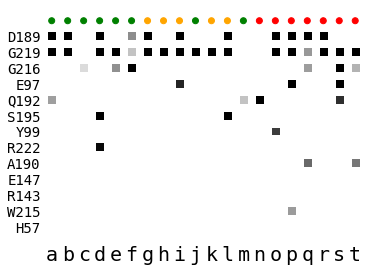

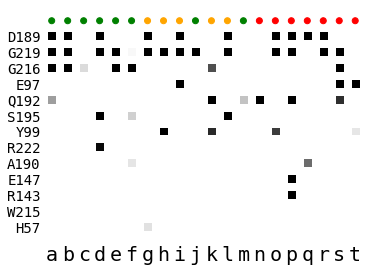

In [5]:
interactions = sc.ps.interactions([cluster, glide_cluster],  'hbond')
unique, keys = [], set()
for code, res in interactions[::-1]:
    if res not in keys:
        unique += [(code, res)]
    keys.add(res)
plot('f10-hbond', 3.9)

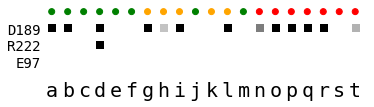

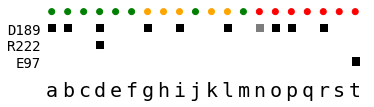

In [6]:
interactions = sc.ps.interactions([cluster, glide_cluster],  'sb')
unique, keys = [], set()
for code, res in interactions[::-1]:
    if res not in keys:
        unique += [(code, res)]
    keys.add(res)
plot('f10-sb', 1.6)